In [8]:
!pip install tqdm

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm
from tqdm import tqdm

%matplotlib inline

In [0]:
def share_path(S_0, r, sigma, Z, dT):
    return S_0 * np.exp(np.cumsum((r - sigma**2/2) * dT + sigma * np.sqrt(dT) * Z))

def european_call_payoff(S_T, K, r, T):
    """S_T is the price of the underlying at expiry.
    K is the strike price
    r is the risk free rate
    T is the time period till maturity"""
    return np.exp(-T*r) * np.maximum(0, S_T - K) #payoff for call option

def euro_uao_call(barrier, paths, K, r, T):
    """barrier is the barrier level,
    paths is a list of share price paths,
    K is the strike price
    r is the risk free rate
    T is the time period of each share price path"""
    prices = []
    for path in paths:
            if np.max(path) > barrier: # knocked out
                    prices.append(0)
            else:
                    prices.append(european_call_payoff(path, K, r, T)) 
    return np.mean(prices)
    
def sumUpPricePath(path, path_total):
    return [x + y for x, y in zip(path_total, path)]

In [0]:
T = 1
L = 150
S_0 = 100
K = 100
V_0 = 100
r = 0.08
sigma_s = 0.30
sigma_v = 0.25
debt = 175
corr = 0.2
recovery_rate = 0.25
frequency = 12
correlation = 0.2

corr_matrix = np.array([[1, correlation], [correlation, 1]])

100%|██████████| 50/50 [02:17<00:00,  5.01s/it]


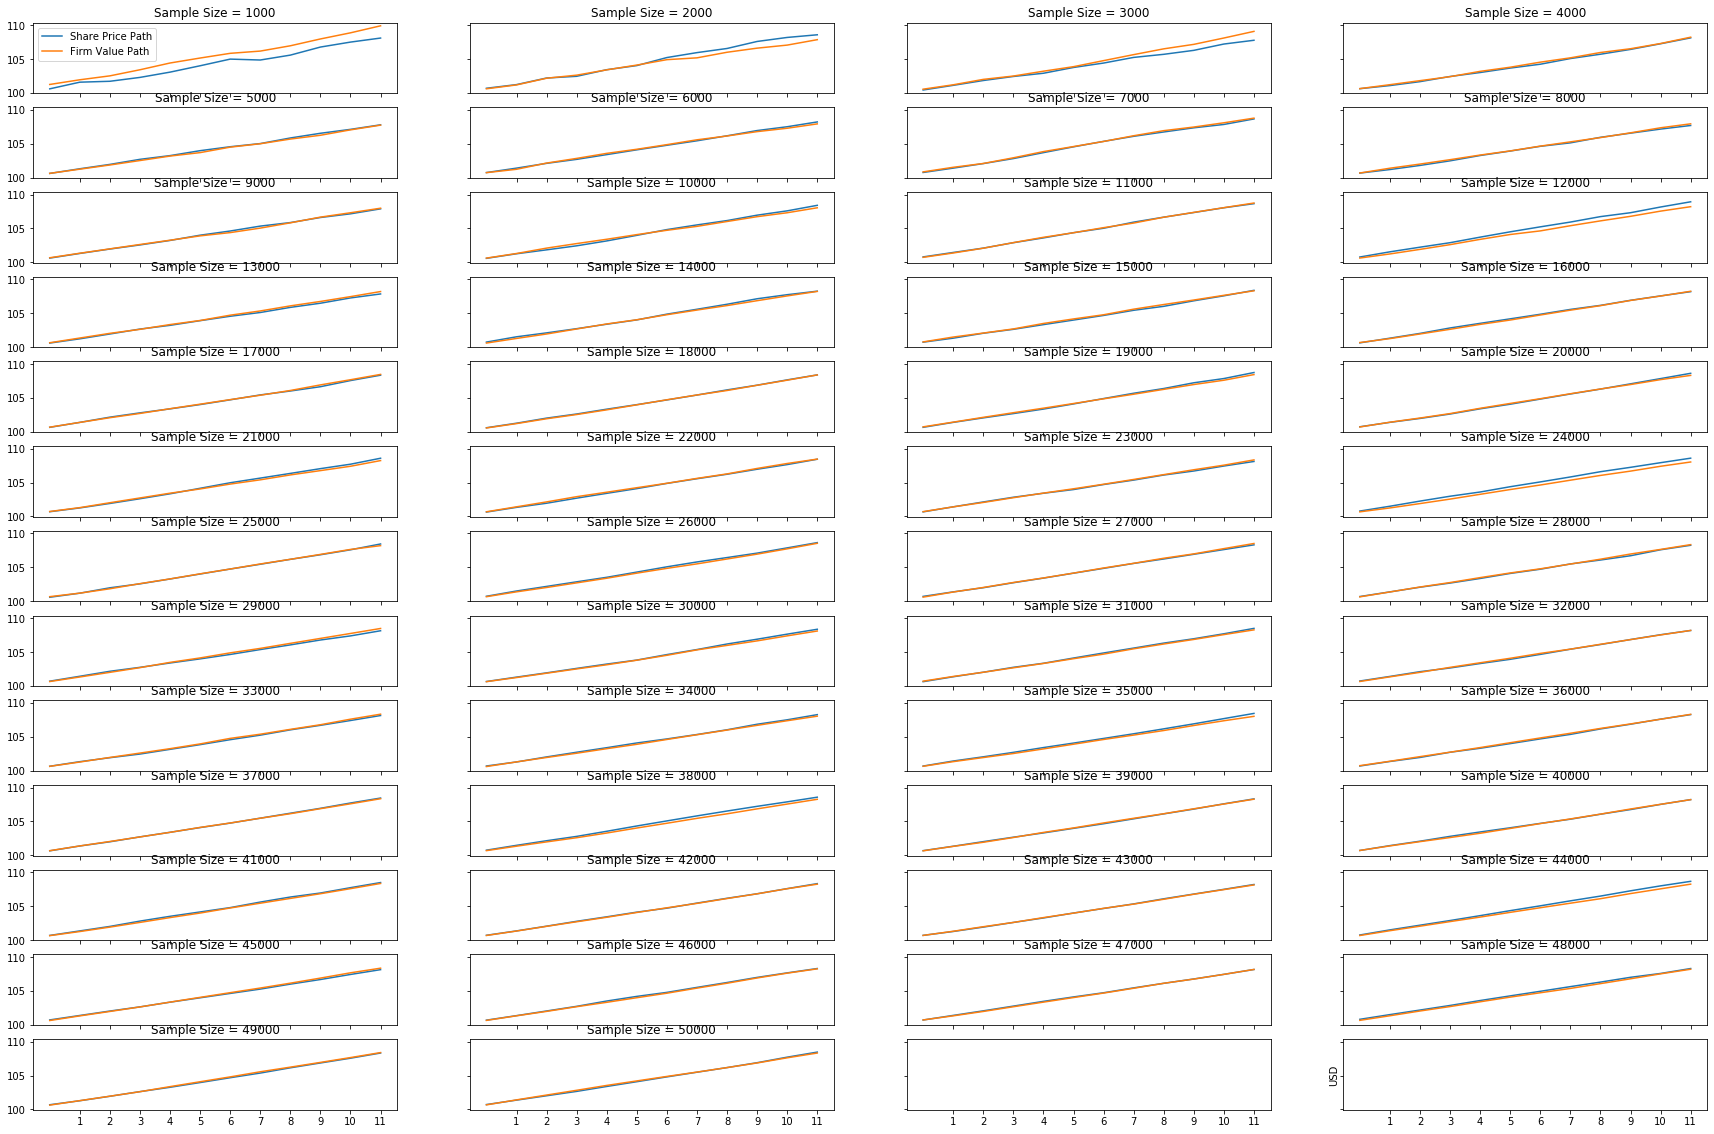

In [12]:
# 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, ..., 50000. 
# Do monthly simulations for the lifetime of the option.
plt.rcParams["figure.figsize"] = (30,20)
fig, ax = plt.subplots(13,4, sharex=True, sharey=True)
plt.xticks (range (1,13))
plt.ylabel ('USD')

for sampleSize in tqdm(range(1000, 51000, 1000)):
    share_path_total = [0] * frequency
    firm_value_total = [0] * frequency
    
    #for each sample size, sum up all price path for each simulation so that the mean can be calculated later
    for i in range(0, sampleSize):
        norm_matrix = norm.rvs(size=np.array([2, frequency]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
        share_price_path = share_path(S_0, r, sigma_s, corr_norm_matrix[0,], T/frequency)
        firm_value_path = share_path(V_0, r, sigma_v, corr_norm_matrix[1,], T/frequency)
        share_path_total = sumUpPricePath(share_price_path, share_path_total)
        firm_value_total = sumUpPricePath(firm_value_path, firm_value_total)
        
    #get the mean path for the sum of all the simulations
    share_path_mean = list(map(lambda totalShare: totalShare/sampleSize, share_path_total))
    firm_value_mean = list(map(lambda totalShare: totalShare/sampleSize, firm_value_total))
#     print("Sample Size: " + str(sampleSize))
#     print("Share price path is " + str(share_path_mean))
#     print("Firm value path is " + str(firm_value_mean))
    row_id = int ((sampleSize / 1000) / 4)
    col_id = int ((sampleSize/1000) % 4 - 1)
    if col_id == -1:
        col_id = 3
        row_id -= 1
    ax [row_id, col_id].title.set_text ('Sample Size = ' + str(sampleSize))
    ax [row_id, col_id].plot (share_path_mean, label = 'Share Price Path')
    ax [row_id, col_id].plot (firm_value_mean, label = 'Firm Value Path')
    if row_id == 0 and col_id == 0:
        ax [row_id, col_id].legend()
#     plt.title ('Sample Size = ' + str(sampleSize))
#     plt.plot (share_path_mean, label = 'Share Price Path')
#     plt.plot (firm_value_mean, label = 'Firm Value Path')
#     plt.xlabel ('Month')
    
#     plt.legend()
    
#     print("\n")
    
plt.show()

In [13]:
#2. Determine Monte Carlo estimates of both the default-free value of the option and the Credit Valuation Adjustment (CVA).
#3. Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA.

call_opt_val, cva_estimates, cva_std = np.array([]), np.array([]), np.array([])

for sampleSize in tqdm(range(1000, 51000, 1000)):
    share_path_total = [0] * frequency
    firm_value_total = [0] * frequency
    
    #for each sample size, sum up all price path for each simulation so that the mean can be calculated later
    for i in range(0, sampleSize):
        norm_matrix = norm.rvs(size=np.array([2, frequency]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
        share_price_path = share_path(S_0, r, sigma_s, corr_norm_matrix[0,], T/frequency)
        firm_value_path = share_path(V_0, r, sigma_v, corr_norm_matrix[1,], T/frequency)
        share_path_total = sumUpPricePath(share_price_path, share_path_total)
        firm_value_total = sumUpPricePath(firm_value_path, firm_value_total)

    #get the mean path for the sum of all the simulations
    share_path_mean = list(map(lambda totalShare: totalShare/sampleSize, share_path_total))
    firm_value_mean = list(map(lambda totalShare: totalShare/sampleSize, firm_value_total))

    ################################################
    #######     terminal value of option   #########
    ################################################

    call_val = euro_uao_call(L, share_path_mean, K, r, T/frequency)
    call_opt_val = np.append(call_opt_val, call_val)

    ################################################
    #######               CVA              #########
    ################################################

    amount_lost = [np.exp(-T/frequency*r) * (1-recovery_rate)*(term_firm_val < debt) * call_val for term_firm_val in firm_value_mean]
    cva_estimates = np.append(cva_estimates, np.mean(amount_lost))
    cva_std = np.append(cva_std, (np.std(amount_lost) / np.sqrt(frequency)))

100%|██████████| 50/50 [02:18<00:00,  5.21s/it]


In [14]:
#2a. Determine Monte Carlo estimates of the default-free value of the option 
#2b. Determine Monte Carlo estimates of the Credit Valuation Adjustment (CVA)
#3. Calculate the Monte Carlo estimates for counterparty risk

# print out the call_opt_val, cva_estimates and cva_std
counter_party_risk = call_opt_val - cva_estimates

for sampleSize, w, x, y, z in zip(range(1000, 51000, 1000), call_opt_val, cva_estimates, cva_std, counter_party_risk):
    print('-' * 20)
    print("For sample Size: " + str(sampleSize))
    print("The European up-and-out call option price is {}.".format(w))
    print("The mean Credit Valuation Adjustment is {}.".format(x))
    print("The counter party risk is {}.".format(z))
    print('-' * 20)

--------------------
For sample Size: 1000
The European up-and-out call option price is 4.429386986916.
The mean Credit Valuation Adjustment is 3.299966964590553.
The counter party risk is 1.1294200223254465.
--------------------
--------------------
For sample Size: 2000
The European up-and-out call option price is 4.3846546749949615.
The mean Credit Valuation Adjustment is 3.266640648324843.
The counter party risk is 1.1180140266701186.
--------------------
--------------------
For sample Size: 3000
The European up-and-out call option price is 4.547763831101375.
The mean Credit Valuation Adjustment is 3.38815968207903.
The counter party risk is 1.159604149022345.
--------------------
--------------------
For sample Size: 4000
The European up-and-out call option price is 3.9271714355626854.
The mean Credit Valuation Adjustment is 2.9258080271427613.
The counter party risk is 1.001363408419924.
--------------------
--------------------
For sample Size: 5000
The European up-and-out call